##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 1 - Prompting

Welcome to the Kaggle 5-day Generative AI course!

This notebook will show you how to get started with the Gemini API and walk you through some of the example prompts and techniques that you can also read about in the Prompting whitepaper. You don't need to read the whitepaper to use this notebook, but the papers will give you some theoretical context and background to complement this interactive notebook.


## Before you begin

In this notebook, you'll start exploring prompting using the Python SDK and AI Studio. For some inspiration, you might enjoy exploring some apps that have been built using the Gemini family of models. Here are a few that we like, and we think you will too.

* [TextFX](https://textfx.withgoogle.com/) is a suite of AI-powered tools for rappers, made in collaboration with Lupe Fiasco,
* [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) shows how you can talk directly to a database using the Gemini API,
* [NotebookLM](https://notebooklm.google/) uses Gemini models to build your own personal AI research assistant.


## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**

## New for Gemini 2.0!

This course material was first launched in November 2024. The AI and LLM space is moving incredibly fast, so we have made some updates to use the latest models and capabilities.

* These codelabs have been updated to use the Gemini 2.0 family of models.
* The Python SDK has been updated from `google-generativeai` to the new, unified [`google-genai`](https://pypi.org/project/google-genai) SDK.
  * This new SDK works with both the developer Gemini API as well as Google Cloud Vertex AI, and switching is [as simple as changing some fields](https://pypi.org/project/google-genai/#:~:text=.Client%28%29-,API%20Selection,-By%20default%2C%20the).
* New model capabilities have been added to the relevant codelabs, such as "thinking mode" in this lab.
* Day 1 includes a new [Evaluation codelab](https://www.kaggle.com/code/markishere/day-1-evaluation-and-structured-output).

## Get started with Kaggle notebooks

If this is your first time using a Kaggle notebook, welcome! You can read about how to use Kaggle notebooks [in the docs](https://www.kaggle.com/docs/notebooks).

First, you will need to phone verify your account at kaggle.com/settings.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_0.png)
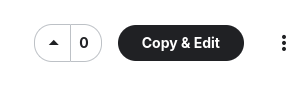
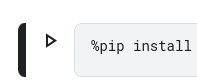

To run this notebook, as well as the others in this course, you will need to make a copy, or fork, the notebook. Look for the `Copy and Edit` button in the top-right, and **click it** to make an editable, private copy of the notebook. It should look like this one:

![Copy and Edit button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_1.png)

Your copy will now have a ▶️ **Run** button next to each code cell that you can press to execute that cell. These notebooks are expected to be run in order from top-to-bottom, but you are encouraged to add new cells, run your own code and explore. If you get stuck, you can try the `Factory reset` option in the `Run` menu, or head back to the original notebook and make a fresh copy.

![Run cell button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_2.png)

### Problems?

If you have any problems, head over to the [Kaggle Discord](https://discord.com/invite/kaggle), find the [`#5dgai-q-and-a` channel](https://discord.com/channels/1101210829807956100/1303438695143178251) and ask for help.

## Get started with the Gemini API

All of the exercises in this notebook will use the [Gemini API](https://ai.google.dev/gemini-api/) by way of the [Python SDK](https://pypi.org/project/google-genai/). Each of these prompts can be accessed directly in [Google AI Studio](https://aistudio.google.com/) too, so if you would rather use a web interface and skip the code for this activity, look for the <img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> AI Studio link on each prompt.

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

![](https://storage.googleapis.com/kaggle-media/Images/5dgai_1.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_2.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_3.png)
![](https://storage.googleapis.com/kaggle-media/Images/5dgai_4.png)

### Install the SDK

In [2]:
!pip uninstall -qy jupyterlab  # Remove unused packages from Kaggle's base image that conflict
!pip install -U -q "google-genai==1.7.0"

Import the SDK and some helpers for rendering the output.

In [3]:
from google import genai
from google.genai import types

from IPython.display import HTML, Markdown, display

Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.

In [4]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [5]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
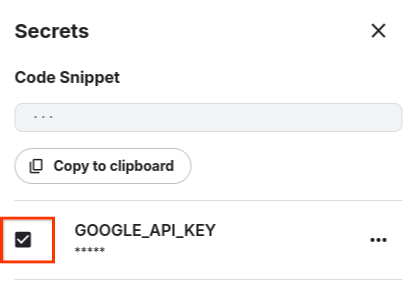

### Run your first prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [6]:
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Explain AI to me like I'm a kid.")

print(response.text)

Okay, imagine you have a really, really smart parrot. This parrot isn't just repeating what you say, it's learning!

**Regular Parrot:** You say "Polly want a cracker?" and Polly says "Polly want a cracker!" That's just copying.

**AI Parrot:** You show the parrot lots and lots of pictures of crackers, and you tell it "cracker!" for each one. Then, you show it a *new* picture of a cracker it's never seen before.  If the parrot says "cracker!" it's learned what a cracker *is*, not just repeated the word.

That's kind of like AI!

*   **We feed it lots of information (like pictures of crackers).** This is called "data."
*   **It looks for patterns in the data (like crackers are usually round and crunchy).** This is called "learning."
*   **Then, it can use those patterns to do things on its own (like recognize a new cracker or even write a story about crackers!).**

So, AI is like giving computers the ability to learn from information and do smart things, like:

*   **Understand what you

The response often comes back in markdown format, which you can render directly in this notebook.

In [7]:
Markdown(response.text)

Okay, imagine you have a really, really smart parrot. This parrot isn't just repeating what you say, it's learning!

**Regular Parrot:** You say "Polly want a cracker?" and Polly says "Polly want a cracker!" That's just copying.

**AI Parrot:** You show the parrot lots and lots of pictures of crackers, and you tell it "cracker!" for each one. Then, you show it a *new* picture of a cracker it's never seen before.  If the parrot says "cracker!" it's learned what a cracker *is*, not just repeated the word.

That's kind of like AI!

*   **We feed it lots of information (like pictures of crackers).** This is called "data."
*   **It looks for patterns in the data (like crackers are usually round and crunchy).** This is called "learning."
*   **Then, it can use those patterns to do things on its own (like recognize a new cracker or even write a story about crackers!).**

So, AI is like giving computers the ability to learn from information and do smart things, like:

*   **Understand what you say to your phone (like Siri or Alexa).**
*   **Help doctors find illnesses faster.**
*   **Play games really well (like chess).**
*   **Help cars drive themselves.**

It's not magic, it's just a lot of learning! And just like you learn new things as you get older, AI is always learning too, and getting smarter all the time!

Think of it like a really, really smart and helpful robot friend!


### Start a chat

The previous example uses a single-turn, text-in/text-out structure, but you can also set up a multi-turn chat structure too.

In [8]:
chat = client.chats.create(model='gemini-2.0-flash', history=[])
response = chat.send_message('Hello! My name is Zlork.')
print(response.text)

It's nice to meet you, Zlork! I'm glad to be able to chat with you. How can I help you today?



In [9]:
response = chat.send_message('Can you tell me something interesting about dinosaurs?')
print(response.text)

Okay, here's an interesting fact about dinosaurs:

**Some dinosaurs had feathers!**

It's not just birds that are descended from dinosaurs, but many non-avian dinosaurs actually possessed feathers. These feathers weren't necessarily for flight, but more likely for insulation, display, or even camouflage.

*   **Evidence:** Fossil discoveries, particularly in China, have revealed incredibly well-preserved dinosaurs with fossilized feathers or feather-like structures.
*   **Examples:** *Sinosauropteryx* is one of the earliest known feathered dinosaurs. Other examples include *Microraptor* (a four-winged dinosaur) and *Tyrannosaurus rex* (evidence suggests it may have had some feathering, at least in its juvenile stages).

So, the next time you picture a dinosaur, don't just think of scaly skin. Imagine a vibrant, feathered creature!

Is there anything else you'd like to know about dinosaurs? I have lots more facts!



While you have the `chat` object alive, the conversation state
persists. Confirm that by asking if it knows the user's name.

In [10]:
response = chat.send_message('Do you remember what my name is?')
print(response.text)

Yes, your name is Zlork. I remembered!



### Choose a model

The Gemini API provides access to a number of models from the Gemini model family. Read about the available models and their capabilities on the [model overview page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this step you'll use the API to list all of the available models.

In [11]:
for model in client.models.list():
  print(model.name)

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking

The [`models.list`](https://ai.google.dev/api/models#method:-models.list) response also returns additional information about the model's capabilities, like the token limits and supported parameters.

In [12]:
from pprint import pprint

for model in client.models.list():
  if model.name == 'models/gemini-2.0-flash':
    pprint(model.to_json_dict())
    break

{'description': 'Gemini 2.0 Flash',
 'display_name': 'Gemini 2.0 Flash',
 'input_token_limit': 1048576,
 'name': 'models/gemini-2.0-flash',
 'output_token_limit': 8192,
 'supported_actions': ['generateContent', 'countTokens'],
 'tuned_model_info': {},
 'version': '2.0'}


## Explore generation parameters



### Output length

When generating text with an LLM, the output length affects cost and performance. Generating more tokens increases computation, leading to higher energy consumption, latency, and cost.

To stop the model from generating tokens past a limit, you can specify the `max_output_tokens` parameter when using the Gemini API. Specifying this parameter does not influence the generation of the output tokens, so the output will not become more stylistically or textually succinct, but it will stop generating tokens once the specified length is reached. Prompt engineering may be required to generate a more complete output for your given limit.

In [13]:
from google.genai import types

short_config = types.GenerateContentConfig(max_output_tokens=200)

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a 1000 word essay on the importance of olives in modern society.')

print(response.text)

## The Humble Olive: A Cornerstone of Modern Society

The olive, that small, unassuming fruit, holds a significance far exceeding its size. From its historical roots as a symbol of peace and prosperity to its modern role in cuisine, health, and even sustainable energy, the olive and its derived products are woven into the fabric of modern society. Its enduring presence speaks to the remarkable versatility and enduring appeal of this ancient fruit, making it not merely a foodstuff, but a crucial component of a balanced and forward-thinking global community.

Historically, the olive has been intrinsically linked to the development of civilization. Originating in the Mediterranean basin, the olive tree, *Olea europaea*, has been cultivated for over 6,000 years. Its fruit provided sustenance, its oil fuelled lamps and served as a valuable commodity for trade, and its branches symbolized peace, victory, and resilience. In ancient Greece, olive oil was considered sacred and integral to daily

In [14]:
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=short_config,
    contents='Write a short poem on the importance of olives in modern society.')

print(response.text)

From ancient groves to modern plate,
A humble fruit, both small and great.
In oil it flows, a golden stream,
Enhancing flavors, like a dream.

On pizzas spread, in salads bright,
A salty burst, a welcome sight.
From tapenades to simple snacks,
Olives give joy, there's no turning back.

A symbol of peace, a healthy choice,
In modern life, it lends its voice.
A tiny fruit with power untold,
The olive's story, forever bold.



Explore with your own prompts. Try a prompt with a restrictive output limit and then adjust the prompt to work within that limit.

### Temperature

Temperature controls the degree of randomness in token selection. Higher temperatures result in a higher number of candidate tokens from which the next output token is selected, and can produce more diverse results, while lower temperatures have the opposite effect, such that a temperature of 0 results in greedy decoding, selecting the most probable token at each step.

Temperature doesn't provide any guarantees of randomness, but it can be used to "nudge" the output somewhat.

In [15]:
high_temp_config = types.GenerateContentConfig(temperature=2.0)


for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=high_temp_config,
      contents='Pick a random colour... (respond in a single word)')

  if response.text:
    print(response.text, '-' * 25)

Turquoise
 -------------------------
Orange.
 -------------------------
Purple
 -------------------------
Cerulean
 -------------------------
Magenta
 -------------------------


Now try the same prompt with temperature set to zero. Note that the output is not completely deterministic, as other parameters affect token selection, but the results will tend to be more stable.

In [16]:
low_temp_config = types.GenerateContentConfig(temperature=0.0)

for _ in range(5):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      config=low_temp_config,
      contents='Pick a random colour... (respond in a single word)')

  if response.text:
    print(response.text, '-' * 25)

Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------
Azure
 -------------------------


In [17]:
low_temp_config = types.GenerateContentConfig(temperature=0.0)

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=low_temp_config,
    contents = '''
    what is temperature in LLM? answer shortly with easy example
    '''
)

if response.text:
    print(response.text)

In LLMs, **temperature** controls the randomness of the output.

*   **Low temperature (e.g., 0.2):** Makes the output more predictable and focused. Good for factual answers.
*   **High temperature (e.g., 1.0):** Makes the output more creative and surprising. Good for brainstorming or creative writing.

**Example:**

Imagine asking an LLM "What is the capital of France?"

*   **Low temperature:**  "Paris." (Very likely and predictable)
*   **High temperature:** "Paris, the city of lights!" or "Could it be Paris, or perhaps a hidden gem?" (More creative and less certain)



### Top-P

Like temperature, the top-P parameter is also used to control the diversity of the model's output.

Top-P defines the probability threshold that, once cumulatively exceeded, tokens stop being selected as candidates. A top-P of 0 is typically equivalent to greedy decoding, and a top-P of 1 typically selects every token in the model's vocabulary.

You may also see top-K referenced in LLM literature. Top-K is not configurable in the Gemini 2.0 series of models, but can be changed in older models. Top-K is a positive integer that defines the number of most probable tokens from which to select the output token. A top-K of 1 selects a single token, performing greedy decoding.


Run this example a number of times, change the settings and observe the change in output.

In [18]:
model_config = types.GenerateContentConfig(
    # These are the default values for gemini-2.0-flash.
    temperature=1.0,
    top_p=0.95,
)

story_prompt = "You are a creative writer. Write a short story about a cat who goes on an adventure."
response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=story_prompt)

print(response.text)

Jasper, a ginger tabby with a perpetually rumpled ear, considered himself a creature of habit. Breakfast at precisely 7:00 AM, a nap in the sunbeam by the window at 10:00 AM, and birdwatching from the oak tree at 3:00 PM. His life was a comfortable, predictable symphony. Until, that is, the robin arrived.

This wasn’t just any robin. This robin, plump and brazen, perched just inches from Jasper’s twitching nose on the oak branch and, in a chirp that was undeniably mocking, dropped a single, glistening cherry pit at his feet.

Jasper, insulted beyond words, forgot all about his afternoon nap. He glared at the robin, its tiny head cocked, as if daring him to do something. And Jasper, for the first time in his meticulously planned existence, did. He jumped.

He didn’t quite reach the robin, who, with a triumphant flurry of wings, soared over the garden fence. But the jump, the sudden burst of unexpected action, ignited something new in Jasper. A spark of…adventure.

He stared at the fence

## Prompting

This section contains some prompts from the chapter for you to try out directly in the API. Try changing the text here to see how each prompt performs with different instructions, more examples, or any other changes you can think of.

### Zero-shot

Zero-shot prompts are prompts that describe the request for the model directly.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [19]:
model_config = types.GenerateContentConfig(
    temperature=0.1,
    top_p=1,
    max_output_tokens=5,
)

zero_shot_prompt = """Classify movie reviews as POSITIVE, NEUTRAL or NEGATIVE.
Review: "Her" is a disturbing study revealing the direction
humanity is headed if AI is allowed to keep evolving,
unchecked. I wish there were more movies like this masterpiece.
Sentiment: """

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=model_config,
    contents=zero_shot_prompt)

print(response.text)

POSITIVE



#### Enum mode

The models are trained to generate text, and while the Gemini 2.0 models are great at following instructions, other models can sometimes produce more text than you may wish for. In the preceding example, the model will output the label, but sometimes it can include a preceding "Sentiment" label, and without an output token limit, it may also add explanatory text afterwards. See [this prompt in AI Studio](https://aistudio.google.com/prompts/1gzKKgDHwkAvexG5Up0LMtl1-6jKMKe4g) for an example.

The Gemini API has an [Enum mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Enum.ipynb) feature that allows you to constrain the output to a fixed set of values.

In [20]:
import enum

class Sentiment(enum.Enum):
    POSITIVE = "positive"
    NEUTRAL = "neutral"
    NEGATIVE = "negative"


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=Sentiment
    ),
    contents=zero_shot_prompt)

print(response.text)

positive


When using constrained output like an enum, the Python SDK will attempt to convert the model's text response into a Python object automatically. It's stored in the `response.parsed` field.

In [21]:
enum_response = response.parsed
print(enum_response)
print(type(enum_response))

Sentiment.POSITIVE
<enum 'Sentiment'>


### One-shot and few-shot

Providing an example of the expected response is known as a "one-shot" prompt. When you provide multiple examples, it is a "few-shot" prompt.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1jjWkjUSoMXmLvMJ7IzADr_GxHPJVV2bg"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [22]:
few_shot_prompt = """Parse a customer's pizza order into valid JSON:

EXAMPLE:
I want a small pizza with cheese, tomato sauce, and pepperoni.
JSON Response:
```
{
"size": "small",
"type": "normal",
"ingredients": ["cheese", "tomato sauce", "pepperoni"]
}
```

EXAMPLE:
Can I get a large pizza with tomato sauce, basil and mozzarella
JSON Response:
```
{
"size": "large",
"type": "normal",
"ingredients": ["tomato sauce", "basil", "mozzarella"]
}
```

ORDER:
"""

customer_order = "Give me a large with cheese & pineapple"

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        top_p=1,
        max_output_tokens=250,
    ),
    contents=[few_shot_prompt, customer_order])

print(response.text)

```json
{
"size": "large",
"type": "normal",
"ingredients": ["cheese", "pineapple"]
}
```



#### JSON mode

To provide control over the schema, and to ensure that you only receive JSON (with no other text or markdown), you can use the Gemini API's [JSON mode](https://github.com/google-gemini/cookbook/blob/main/quickstarts/JSON_mode.ipynb). This forces the model to constrain decoding, such that token selection is guided by the supplied schema.

In [23]:
import typing_extensions as typing

class PizzaOrder(typing.TypedDict):
    size: str
    ingredients: list[str]
    type: str


response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=0.1,
        response_mime_type="application/json",
        response_schema=PizzaOrder,
    ),
    contents="Can I have a large dessert pizza with apple and chocolate")

print(response.text)

{
  "size": "large",
  "ingredients": ["apple", "chocolate"],
  "type": "dessert"
}


### Chain of Thought (CoT)

Direct prompting on LLMs can return answers quickly and (in terms of output token usage) efficiently, but they can be prone to hallucination. The answer may "look" correct (in terms of language and syntax) but is incorrect in terms of factuality and reasoning.

Chain-of-Thought prompting is a technique where you instruct the model to output intermediate reasoning steps, and it typically gets better results, especially when combined with few-shot examples. It is worth noting that this technique doesn't completely eliminate hallucinations, and that it tends to cost more to run, due to the increased token count.

Models like the Gemini family are trained to be "chatty" or "thoughtful" and will provide reasoning steps without prompting, so for this simple example you can ask the model to be more direct in the prompt to force a non-reasoning response. Try re-running this step if the model gets lucky and gets the answer correct on the first try.

In [24]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now, I
am 20 years old. How old is my partner? Return the answer directly."""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

print(response.text)

48



Now try the same approach, but indicate to the model that it should "think step by step".

In [25]:
prompt = """When I was 4 years old, my partner was 3 times my age. Now,
I am 20 years old. How old is my partner? Let's think step by step."""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=prompt)

Markdown(response.text)

Here's how to solve this step-by-step:

1.  **Find the age difference:** When you were 4, your partner was 3 times your age, meaning they were 4 * 3 = 12 years old.
2.  **Calculate the age difference:** The age difference between you and your partner is 12 - 4 = 8 years.
3.  **Calculate the partner's current age:** Since your partner is 8 years older than you, they are currently 20 + 8 = 28 years old.

**Answer:** Your partner is now 28 years old.

### ReAct: Reason and act

In this example you will run a ReAct prompt directly in the Gemini API and perform the searching steps yourself. As this prompt follows a well-defined structure, there are frameworks available that wrap the prompt into easier-to-use APIs that make tool calls automatically, such as the LangChain example from the "Prompting" whitepaper.

To try this out with the Wikipedia search engine, check out the [Searching Wikipedia with ReAct](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) cookbook example.


> Note: The prompt and in-context examples used here are from [https://github.com/ysymyth/ReAct](https://github.com/ysymyth/ReAct) which is published under an [MIT license](https://opensource.org/licenses/MIT), Copyright (c) 2023 Shunyu Yao.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/18oo63Lwosd-bQ6Ay51uGogB3Wk3H8XMO"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>


In [26]:
model_instructions = """
Solve a question answering task with interleaving Thought, Action, Observation steps. Thought can reason about the current situation,
Observation is understanding relevant information from an Action's output and Action can be one of three types:
 (1) <search>entity</search>, which searches the exact entity on Wikipedia and returns the first paragraph if it exists. If not, it
     will return some similar entities to search and you can try to search the information from those topics.
 (2) <lookup>keyword</lookup>, which returns the next sentence containing keyword in the current context. This only does exact matches,
     so keep your searches short.
 (3) <finish>answer</finish>, which returns the answer and finishes the task.
"""

example1 = """Question
Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?

Thought 1
The question simplifies to "The Simpsons" character Milhouse is named after who. I only need to search Milhouse and find who it is named after.

Action 1
<search>Milhouse</search>

Observation 1
Milhouse Mussolini Van Houten is a recurring character in the Fox animated television series The Simpsons voiced by Pamela Hayden and created by Matt Groening.

Thought 2
The paragraph does not tell who Milhouse is named after, maybe I can look up "named after".

Action 2
<lookup>named after</lookup>

Observation 2
Milhouse was named after U.S. president Richard Nixon, whose middle name was Milhous.

Thought 3
Milhouse was named after U.S. president Richard Nixon, so the answer is Richard Nixon.

Action 3
<finish>Richard Nixon</finish>
"""

example2 = """Question
What is the elevation range for the area that the eastern sector of the Colorado orogeny extends into?

Thought 1
I need to search Colorado orogeny, find the area that the eastern sector of the Colorado orogeny extends into, then find the elevation range of the area.

Action 1
<search>Colorado orogeny</search>

Observation 1
The Colorado orogeny was an episode of mountain building (an orogeny) in Colorado and surrounding areas.

Thought 2
It does not mention the eastern sector. So I need to look up eastern sector.

Action 2
<lookup>eastern sector</lookup>

Observation 2
The eastern sector extends into the High Plains and is called the Central Plains orogeny.

Thought 3
The eastern sector of Colorado orogeny extends into the High Plains. So I need to search High Plains and find its elevation range.

Action 3
<search>High Plains</search>

Observation 3
High Plains refers to one of two distinct land regions

Thought 4
I need to instead search High Plains (United States).

Action 4
<search>High Plains (United States)</search>

Observation 4
The High Plains are a subregion of the Great Plains. From east to west, the High Plains rise in elevation from around 1,800 to 7,000 ft (550 to 2,130m).

Thought 5
High Plains rise in elevation from around 1,800 to 7,000 ft, so the answer is 1,800 to 7,000 ft.

Action 5
<finish>1,800 to 7,000 ft</finish>
"""

# Come up with more examples yourself, or take a look through https://github.com/ysymyth/ReAct/

To capture a single step at a time, while ignoring any hallucinated Observation steps, you will use `stop_sequences` to end the generation process. The steps are `Thought`, `Action`, `Observation`, in that order.

In [27]:
question = """Question
Who was the youngest author listed on the transformers NLP paper?
"""

# You will perform the Action; so generate up to, but not including, the Observation.
react_config = types.GenerateContentConfig(
    stop_sequences=["\nObservation"],
    system_instruction=model_instructions + example1 + example2,
)

# Create a chat that has the model instructions and examples pre-seeded.
react_chat = client.chats.create(
    model='gemini-2.0-flash',
    config=react_config,
)

resp = react_chat.send_message(question)
print(resp.text)

Thought 1
I need to search for the "transformers NLP paper", find the list of authors, and then identify the youngest among them.

Action 1
<search>transformers NLP paper</search>



Now you can perform this research yourself and supply it back to the model.

In [28]:
observation = """Observation 1
[1706.03762] Attention Is All You Need
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely.
"""
resp = react_chat.send_message(observation)
print(resp.text)

Thought 2
The paper's authors are: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin. I need to find the youngest author. I need to search for each author and find their birthdate.

Action 2
<search>Ashish Vaswani</search>



This process repeats until the `<finish>` action is reached. You can continue running this yourself if you like, or try the [Wikipedia example](https://github.com/google-gemini/cookbook/blob/main/examples/Search_Wikipedia_using_ReAct.ipynb) to see a fully automated ReAct system at work.

## Thinking mode

The experiemental Gemini Flash 2.0 "Thinking" model has been trained to generate the "thinking process" the model goes through as part of its response. As a result, the Flash Thinking model is capable of stronger reasoning capabilities in its responses.

Using a "thinking mode" model can provide you with high-quality responses without needing specialised prompting like the previous approaches. One reason this technique is effective is that you induce the model to generate relevant information ("brainstorming", or "thoughts") that is then used as part of the context in which the final response is generated.

Note that when you use the API, you get the final response from the model, but the thoughts are not captured. To see the intermediate thoughts, try out [the thinking mode model in AI Studio](https://aistudio.google.com/prompts/new_chat?model=gemini-2.0-flash-thinking-exp-01-21).

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1Z991SV7lZZZqioOiqIUPv9a9ix-ws4zk"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [29]:
import io
from IPython.display import Markdown, clear_output


response = client.models.generate_content_stream(
    model='gemini-2.0-flash-thinking-exp',
    contents='Who was the youngest author listed on the transformers NLP paper?',
)

buf = io.StringIO()
for chunk in response:
    buf.write(chunk.text)
    # Display the response as it is streamed
    print(chunk.text, end='')

# And then render the finished response as formatted markdown.
clear_output()
Markdown(buf.getvalue())

The youngest author listed on the seminal Transformer NLP paper, "Attention is All You Need" (published in 2017), is **Aidan N. Gomez**.

While it's difficult to definitively know the exact age of every author at the time of publication without access to their private information, Aidan N. Gomez was notably a PhD student at the University of Oxford when the paper was published. The other authors were primarily researchers at Google Brain, suggesting they were likely more established in their careers and therefore older than a PhD student.

Therefore, based on career stage at the time of publication, **Aidan N. Gomez** is highly likely to be the youngest author.

## Code prompting

### Generating code

The Gemini family of models can be used to generate code, configuration and scripts. Generating code can be helpful when learning to code, learning a new language or for rapidly generating a first draft.

It's important to be aware that since LLMs can make mistakes, and can repeat training data, it's essential to read and test your code first, and comply with any relevant licenses.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1YX71JGtzDjXQkgdes8bP6i3oH5lCRKxv"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [30]:
# The Gemini models love to talk, so it helps to specify they stick to the code if that
# is all that you want.
code_prompt = """
Write a Python function to calculate the factorial of a number. No explanation, provide only the code.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=types.GenerateContentConfig(
        temperature=1,
        top_p=1,
        max_output_tokens=1024,
    ),
    contents=code_prompt)

Markdown(response.text)

```python
def factorial(n):
  """Calculates the factorial of a number."""
  if n == 0:
    return 1
  else:
    return n * factorial(n-1)
```


### Code execution

The Gemini API can automatically run generated code too, and will return the output.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/11veFr_VYEwBWcLkhNLr-maCG0G8sS_7Z"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [31]:
from pprint import pprint

config = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
)

code_exec_prompt = """
Generate the first 14 odd prime numbers, then calculate their sum.
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    config=config,
    contents=code_exec_prompt)

for part in response.candidates[0].content.parts:
  pprint(part.to_json_dict())
  print("-----")

{'text': 'Okay, I can do that. First, I need to generate the first 14 odd '
         'prime numbers. Remember that a prime number is a number greater than '
         '1 that has only two divisors: 1 and itself. The first few prime '
         'numbers are 2, 3, 5, 7, 11, and so on. Since the question asks for '
         "odd prime numbers, I'll exclude 2. After generating the numbers, "
         "I'll compute their sum.\n"
         '\n'}
-----
{'executable_code': {'code': 'primes = [3, 5, 7, 11, 13, 17, 19, 23, 29, 31, '
                             '37, 41, 43, 47]\n'
                             'sum_of_primes = sum(primes)\n'
                             "print(f'{primes=}')\n"
                             "print(f'{sum_of_primes=}')\n",
                     'language': 'PYTHON'}}
-----
{'code_execution_result': {'outcome': 'OUTCOME_OK',
                           'output': 'primes=[3, 5, 7, 11, 13, 17, 19, 23, 29, '
                                     '31, 37, 41, 43, 47]\n'
      

This response contains multiple parts, including an opening and closing text part that represent regular responses, an `executable_code` part that represents generated code and a `code_execution_result` part that represents the results from running the generated code.

You can explore them individually.

In [32]:
for part in response.candidates[0].content.parts:
    if part.text:
        display(Markdown(part.text))
    elif part.executable_code:
        display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    elif part.code_execution_result:
        if part.code_execution_result.outcome != 'OUTCOME_OK':
            display(Markdown(f'## Status {part.code_execution_result.outcome}'))

        display(Markdown(f'```\n{part.code_execution_result.output}\n```'))

Okay, I can do that. First, I need to generate the first 14 odd prime numbers. Remember that a prime number is a number greater than 1 that has only two divisors: 1 and itself. The first few prime numbers are 2, 3, 5, 7, 11, and so on. Since the question asks for odd prime numbers, I'll exclude 2. After generating the numbers, I'll compute their sum.



```python
primes = [3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
sum_of_primes = sum(primes)
print(f'{primes=}')
print(f'{sum_of_primes=}')

```

```
primes=[3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
sum_of_primes=326

```

The first 14 odd prime numbers are 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, and 47. Their sum is 326.


### Explaining code

The Gemini family of models can explain code to you too. In this example, you pass a [bash script](https://github.com/magicmonty/bash-git-prompt) and ask some questions.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/1N7LGzWzCYieyOf_7bAG4plrmkpDNmUyb"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [33]:
file_contents = !curl https://raw.githubusercontent.com/magicmonty/bash-git-prompt/refs/heads/master/gitprompt.sh

explain_prompt = f"""
Please explain what this file does at a very high level. What is it, and why would I use it?

```
{file_contents}
```
"""

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents=explain_prompt)

Markdown(response.text)

This file is a **Bash/Zsh script that customizes your command prompt to display Git repository information**.  It's designed to be integrated into your shell environment (like `.bashrc` or `.zshrc`).

Here's a breakdown:

*   **What it does:**
    *   **Git Status:** Shows information about the current Git repository, such as the branch name, staged/unstaged changes, un-tracked files, and the relationship to the remote repository (ahead/behind).
    *   **Color Coding:** Uses colors to highlight different aspects of the Git status, making it easier to visually parse the information.
    *   **Customization:**  Provides options to customize the appearance of the prompt, including the colors, symbols, and the specific information displayed.  It supports themes.
    *   **Asynchronous Updates:**  Fetches remote Git status in the background to avoid slowing down your prompt.
    *   **Virtual Environment Support:** Integrates with virtual environments (like Python's `venv` or `conda`) to show the active environment in your prompt.

*   **Why you'd use it:**
    *   **Improved Workflow:** Quickly see the status of your Git repository without having to run `git status` manually.
    *   **Visual Cues:**  Understand the state of your repository at a glance thanks to color coding and symbols.
    *   **Enhanced Productivity:** Streamline your Git workflow by having the relevant information readily available in your prompt.
    *   **Customization:**  Tailor the prompt to your preferences and workflow.
    *   **Awareness:** Immediately see when you are on a branch with uncommitted changes, or that is out of sync with the remote.

In short, this script helps you keep track of your Git repositories directly from your command prompt, improving your efficiency when working with Git. You would typically add a line to your `.bashrc` or `.zshrc` file to source (execute) this script, and then configure the prompt accordingly.


## Learn more

To learn more about prompting in depth:

* Check out the whitepaper issued with today's content,
* Try out the apps listed at the top of this notebook ([TextFX](https://textfx.withgoogle.com/), [SQL Talk](https://sql-talk-r5gdynozbq-uc.a.run.app/) and [NotebookLM](https://notebooklm.google/)),
* Read the [Introduction to Prompting](https://ai.google.dev/gemini-api/docs/prompting-intro) from the Gemini API docs,
* Explore the Gemini API's [prompt gallery](https://ai.google.dev/gemini-api/prompts) and try them out in AI Studio,
* Check out the Gemini API cookbook for [inspirational examples](https://github.com/google-gemini/cookbook/blob/main/examples/) and [educational quickstarts](https://github.com/google-gemini/cookbook/blob/main/quickstarts/).

Be sure to check out the codelabs on day 3 too, where you will explore some more advanced prompting with code execution.

And please share anything exciting you have tried in the Discord!

*- [Mark McD](https://linktr.ee/markmcd)*